In [7]:
%load_ext autoreload
%autoreload 2

import itertools
import matplotlib.pyplot as plt
import numpy as np
from dqalgo.nisq.eval import get_truth_table_tomography_for_Fanout
from dqalgo.nisq.utils import get_depolarizing_noise_model
from dqalgo.vis import vis_bar_fid_vs_input, vis_line_avg_fid_vs_n_trgts
from dqalgo.data_mgr import NISQFanoutDataMgr


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Visualize fidelities v.s. n_trgts

{'0000': np.float64(0.9955957701296244), '0001': np.float64(0.993140536379419), '0010': np.float64(0.9941233575366791), '0011': np.float64(0.9938777433618282), '0100': np.float64(0.995840960570512), '0101': np.float64(0.993140536379419), '0110': np.float64(0.9948598362332254), '0111': np.float64(0.9948598362332254), '1000': np.float64(0.995840960570512), '1001': np.float64(0.9948598362332254), '1010': np.float64(0.9951052080056662), '1011': np.float64(0.9955957701296244), '1100': np.float64(0.9946144039274718), '1101': np.float64(0.995840960570512), '1110': np.float64(0.9933863328282708), '1111': np.float64(0.9953505192895616)}
{'000000': np.float64(0.9921567416492215), '000001': np.float64(0.9899396288410723), '000010': np.float64(0.993140536379419), '000011': np.float64(0.9901862198596787), '000100': np.float64(0.9916644782889019), '000101': np.float64(0.9909256247317454), '000110': np.float64(0.9919106405064924), '000111': np.float64(0.9904327494837799), '001000': np.float64(0.99092

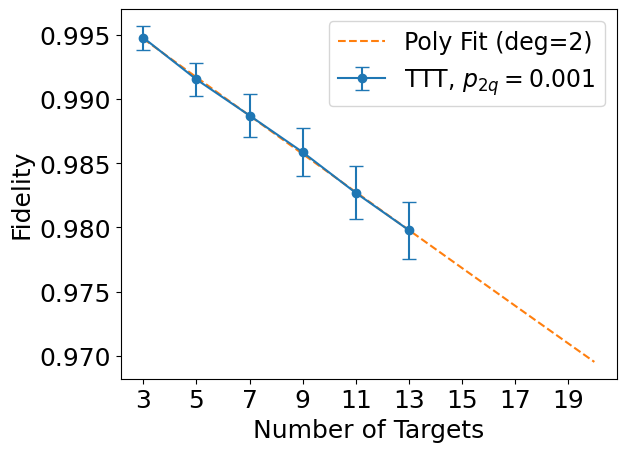

In [50]:
all_n_trgts_lst = [3, 5, 7, 9, 11, 13]
# simulation time for t=11: 643 s
p_2q_lst = [0.001]

dmgr = NISQFanoutDataMgr()

n_trgts_lst_lst = [[3,5,7],[9],[11],[13]]
input_to_fid_lst = []
for n_trgts_lst in n_trgts_lst_lst:
    tmp_input_to_fid_lst, _, _ = dmgr.load(n_trgts=n_trgts_lst, p_2q=p_2q_lst)
    input_to_fid_lst.extend(tmp_input_to_fid_lst)

for input_to_fid in input_to_fid_lst:
    print(input_to_fid)
assert isinstance(input_to_fid_lst, list)
assert isinstance(input_to_fid_lst[0], dict)

avg_fids = [np.mean(list(input_to_fid.values())) for input_to_fid in input_to_fid_lst]
avg_fids = np.array(avg_fids)
print(avg_fids)
p_2q_idx = 0

coeffs = np.polyfit(all_n_trgts_lst, avg_fids, deg=2)
print(coeffs)
fitted_fn = np.poly1d(coeffs)

# Generate smooth x values for plotting the curve
x_max = 20
x_fit = np.linspace(min(all_n_trgts_lst), x_max, 300)
y_fit = fitted_fn(x_fit)

fig, ax = plt.subplots()


params = {'legend.fontsize': 17,
            #   'figure.figsize': (8, 5),
              'axes.labelsize': 18,  # 'x-large',
              'axes.titlesize': 20,  # 'x-large',
              'xtick.labelsize': 18,
              'ytick.labelsize': 18,
              'pdf.fonttype': 42,
              'ps.fonttype': 42, }
plt.rcParams.update(params)

# ax.plot(n_trgts_lst, avg_fids, marker='o')
std_fids = [np.std(list(input_to_fid.values())) for input_to_fid in input_to_fid_lst]
ax.errorbar(all_n_trgts_lst, avg_fids, yerr=std_fids, fmt='-o', capsize=5, label=f"TTT, $p_{{2q}}={p_2q_lst[0]}$")
ax.plot(x_fit, y_fit, label=f'Poly Fit (deg=2)', linestyle='--')
ax.set_xticks(range(min(all_n_trgts_lst), x_max+1, 2))
ax.set_xlabel("Number of Targets")
ax.set_ylabel("Fidelity")
ax.legend()
# ax.set_title("Fidelity vs Number of Targets")
# vis_line_avg_fid_vs_n_trgts(ax, n_trgts_lst, list(avg_fids))
plt.show()

# Visualize one truth table tomography

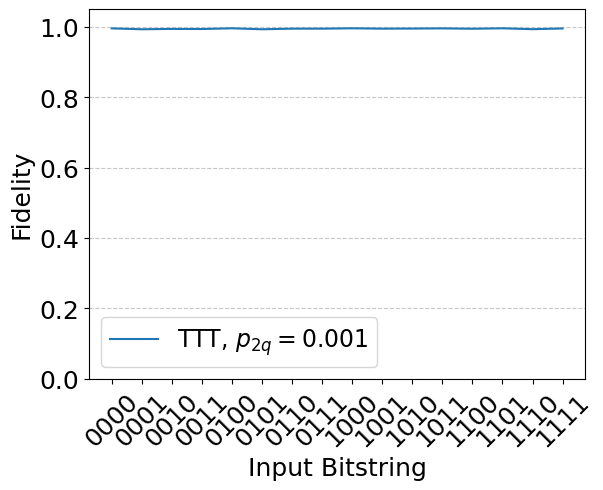

In [46]:
n_trgts = 3
p_2q = 0.001

input_to_fid = input_to_fid_lst[0]
fig, ax = plt.subplots()
# vis_bar_fid_vs_input(ax, input_to_fid)
x = list(input_to_fid.keys())
y = list(input_to_fid.values())
ax.plot(x, y, label=f"TTT, $p_{{2q}}={p_2q}$")
ax.set_xticks(x, x, rotation=45)
ax.set_xlabel("Input Bitstring")
ax.set_ylabel("Fidelity")
ax.set_ylim(0, 1.05)  # Set y-axis to go up to 1.05 for clarity
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend()
# ax.set_title(f"TTT, $n_{{trgts}}={n_trgts}$, $p_{{2q}}={p_2q}$")
plt.show()
